# Choosing the location for the well

We need to decide where to drill a new well.
We were provided with oil samples in three regions: in each 10,000 fields, where the quality of oil and the volume of its reserves were measured. Let's build a machine learning model that will help determine the region where mining will bring the greatest profit. Let's analyze the possible profits and risks with the *Bootstrap technique.*

Steps to select a location:

- We are looking for deposits in the selected region, we determine the values of the features for each;
- We build a model and estimate the volume of stocks;
- We choose the deposit with the highest estimates of values. The number of deposits depends on the company's budget and the cost of developing one well;
- The profit is equal to the total profit of the selected fields.


---


- id — the unique identifier of the well;
- f0, f1, f2 — three signs of points (no matter what they mean, but the signs themselves are significant);
- product — the volume of reserves in the well (thousand barrels).



## Loading and preparing data

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor

RANDOM_STATE = 42
AMOUNT_OIL_WELLS = 200 # number of wells in the region for development
DEVELOPMENT_BUDGET = 10_000_000_000 # budget for the development of one region
PROFIT_PER_UNIT = 450_000 # revenue per unit of product

In [3]:
# Uploading datasets
data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Preparation of the first dataset

In [4]:
# Creating a function to display information about a dataset
def data_info(data):
    display(data.head()), 
    print('-' * 20)
    print('Missing values')
    display(data.isna().sum()), 
    print('-' * 20)
    print('Duplicates')
    display(data.duplicated().sum()), 
    print('-' * 20)
    print('Info')
    display(data.info()), 
    print('-' * 20)
    print('Discribe')
    display(data.describe())

In [5]:
# Check the first dataset
data_info(data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


--------------------
Missing values


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--------------------
Duplicates


0

--------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

--------------------
Discribe


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


There are no omissions and duplicates, we divide it into training and test samples.

In [6]:
X_0 = data_0.drop(['id', 'product'], axis=1)
y_0 = data_0['product']

In [7]:
X_0_train, X_0_test, y_0_train, y_0_test = train_test_split(X_0, y_0, test_size=0.25, random_state=RANDOM_STATE)

In [8]:
X_0_train.shape, X_0_test.shape, y_0_train.shape, y_0_test.shape

((75000, 3), (25000, 3), (75000,), (25000,))

### Preparation of the second dataset

In [9]:
data_info(data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


--------------------
Missing values


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--------------------
Duplicates


0

--------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

--------------------
Discribe


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


There are no omissions and duplicates, we divide it into training and test samples.

In [10]:
X_1 = data_1.drop(['id', 'product'], axis=1)
y_1 = data_1['product']

In [11]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y_1, test_size=0.25, random_state=RANDOM_STATE)

In [12]:
X_1_train.shape, X_1_test.shape, y_1_train.shape, y_1_test.shape

((75000, 3), (25000, 3), (75000,), (25000,))

### Preparation of the third dataset

In [13]:
data_info(data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


--------------------
Missing values


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--------------------
Duplicates


0

--------------------
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

--------------------
Discribe


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


There are also no omissions and duplicates in the third dataset, we divide it into training and test samples.

In [14]:
X_2 = data_2.drop(['id', 'product'], axis=1)
y_2 = data_2['product']

In [15]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.25, random_state=RANDOM_STATE)

In [16]:
X_2_train.shape, X_2_test.shape, y_2_train.shape, y_2_test.shape

((75000, 3), (25000, 3), (75000,), (25000,))

All the necessary data have been prepared, we are starting training

## Training and check of the model

In [17]:
# The function of calculating the average stock of raw materials and RMSE
def model_lg(X_train, X_test, y_train, y_test):
    model = CatBoostRegressor(random_state=RANDOM_STATE, verbose=False)
    param = {'max_depth': [3, 5, 7],
             'n_estimators': [1000, 2000, 3000]}
    grid = GridSearchCV(model, param, cv=4, n_jobs=-1)         
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred) ** 0.5
    print('The average stock of raw materials:', pd.Series(y_pred).mean())
    print('RMSE:', rmse)
    return model, pd.Series(y_pred, index=y_test.index), rmse

### The first region

In [18]:
model_0, y_0_pred , rmse_0 =  model_lg(X_0_train, X_0_test, y_0_train, y_0_test)

The average stock of raw materials: 92.48936830833789
RMSE: 37.20160004834114


### The second region

In [19]:
model_1, y_1_pred, rmse_1 =  model_lg(X_1_train, X_1_test, y_1_train, y_1_test)

The average stock of raw materials: 68.72667396646662
RMSE: 2.044303221296074


### The third region

In [20]:
model_2, y_2_pred, rmse_2 =  model_lg(X_2_train, X_2_test, y_2_train, y_2_test)

The average stock of raw materials: 94.759388351664
RMSE: 37.63567482273371


The largest predicted average reserves of deposits were obtained in the third region.

## Profit calculation

In [21]:
print('Sufficient volume of raw materials for break-even development of a new well:',\
      (DEVELOPMENT_BUDGET / AMOUNT_OIL_WELLS / PROFIT_PER_UNIT))

Sufficient volume of raw materials for break-even development of a new well: 111.11111111111111


No region satisfies the minimum average volume of raw materials reserves per well, if we take the average for all wells, let's see what happens if we take the top 200.

In [22]:
# Profit calculation function based on predictions based on validation sample
def profit(y_true, y_pred, count):
     return round(y_true[y_pred.sort_values(ascending=False).index][:count].sum()\
                  * PROFIT_PER_UNIT - DEVELOPMENT_BUDGET, 0)

In [23]:
profit(y_0_test, y_0_pred, AMOUNT_OIL_WELLS)

3711418360.0

In [24]:
profit(y_1_test, y_1_pred, AMOUNT_OIL_WELLS)

2413656101.0

In [25]:
profit(y_2_test, y_2_pred, AMOUNT_OIL_WELLS)

3498195093.0

If we explore all the deposits in the regions and take the best of the best, then we will easily cover the costs and get a good profit. But since our budget is limited, let's see what happens if we take only 500 random wells.

## Calculation of profit and risks

In [26]:
# Bootstrap
def bootstrap(y_test, y_pred):
    state = np.random.RandomState(RANDOM_STATE)
    values = []
    for i in range(1000):
        subsample = y_test.sample(n=500, replace=True, random_state=state)
        probs_subsample = y_pred[subsample.index]
        values.append(profit(subsample, probs_subsample, AMOUNT_OIL_WELLS))

    values=pd.Series(values)
    plt.figure(figsize=(15,10))
    plt.style.use('dark_background')
    ax = sns.histplot(values, kde=False, bins=100)
    bars = ax.patches
    for bar in bars:
        if bar.get_x() >= values.quantile(0.05) and\
        bar.get_x() + bar.get_width() <= values.quantile(0.95):
            bar.set_facecolor('b')
    plt.axvline(values.mean(), color='r', linestyle='--', label='Mean')
    plt.title('Confidence interval of profit distribution')
    plt.xlabel('Profit value')
    plt.grid()
    plt.show()
    print('Average profit:', round(values.mean(),0))
    print('Confidence interval', round(values.quantile(.025),0), round(values.quantile(.975),0))
    print('Probability of loss:', values[values < 0].count() / len(values))
    return [round(values.mean(),0), 
            round(values.quantile(.025),0), round(values.quantile(.975),0),
            values[values < 0].count() / len(values)]

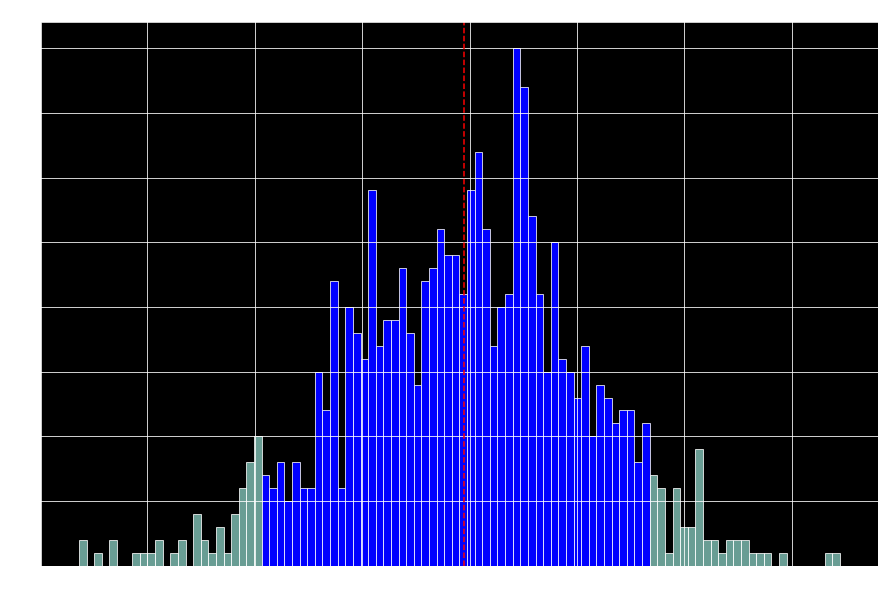

Average profit: 488140877.0
Confidence interval -48138457.0 1027318959.0
Probability of loss: 0.044


In [27]:
region1 = bootstrap(y_0_test, y_0_pred)

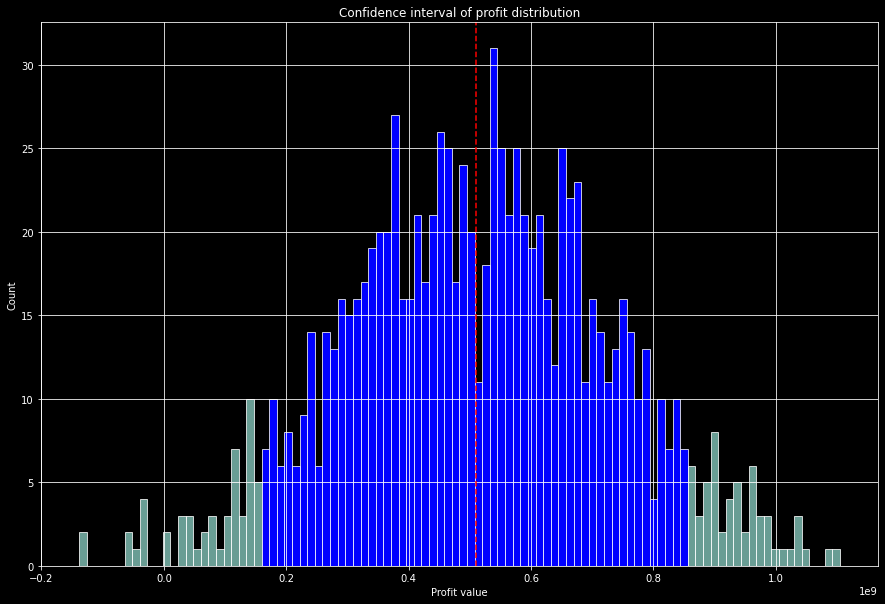

Average profit: 510729022.0
Confidence interval 98870650.0 940034759.0
Probability of loss: 0.009


In [28]:
region2 = bootstrap(y_1_test, y_1_pred)

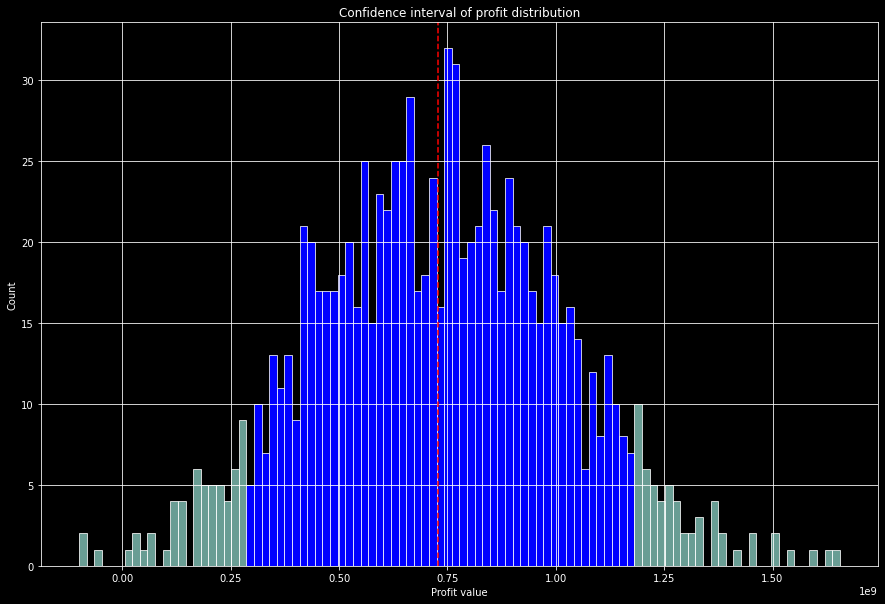

Average profit: 728482940.0
Confidence interval 184331708.0 1274524996.0
Probability of loss: 0.003


In [29]:
region3 = bootstrap(y_2_test, y_2_pred)

In [30]:
pd.DataFrame([region1, region2, region3], columns=['Average profit', 'Min profit', 
                                                   'Max profit', 'Probability of loss'],
            index=['region1', 'regoin2', 'region3'])

,Average profit,Min profit,Max profit,Probability of loss
region1,488140877.0,-48138457.0,1.027319e+09,0.044
regoin2,510729022.0,98870650.0,9.400348e+08,0.009
region3,728482940.0,184331708.0,1.274525e+09,0.003


## Conclusion
Catboost models were trained on data from three regions, and predictions were made on a test sample. According to the results of the forecasts, it was found that when examining all wells, all three regions make a profit. After conducting an initial analysis, selecting 500 random wells in the region and the top 200 of them, we see that region number 1 does not meet the break-even criteria. In regions No. 2 and 3, the probability of loss is less than 1%, which meets the selection criteria. The amount of profit that we can get in these regions is on average 510 and 728 million, respectively.